In [3]:
# Syntax error being tracked here: https://github.com/microsoft/vscode-jupyter/issues/6635
# If it's annoying, workaround here: https://stackoverflow.com/a/35597119/768439
%load_ext autoreload
%autoreload 2

# TODO: Use this to profile: https://stackoverflow.com/questions/45893768/how-do-i-find-out-what-parts-of-my-code-are-inefficient-in-python
%load_ext line_profiler

In [4]:
import sys
sys.path.append('../')

from src.serialization_lib import *
from src.data_types import *

import math
from collections import defaultdict
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = "{:,.2f}".format

In [5]:
INITIAL_PORTFOLIO_VALUE = 10000

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

DATA_PROCESSED_BASE_PATH = '/Volumes/SDCard/TipBackTest/processed_data'

DEVELOPMENT = False
env = 'dev' if DEVELOPMENT else 'prod'

In [21]:
all_df_results = defaultdict(lambda: defaultdict(pd.DataFrame))
all_rebalance_days = [90, 180, 730, 1825]
all_portfolio_sizes = [5, 10, 15, 30, 60]

for rebalance_days in all_rebalance_days:
    for portfolio_size in all_portfolio_sizes:
        filename = get_feather_filename('df_res', BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE, env)
        filename = os.path.join(DATA_PROCESSED_BASE_PATH, filename)

        # TODO: Need to fix the source code that generates these dataframes
        df = read_df_from_feather(filename)
        df.rename(columns={'index': 'date'}, inplace=True)
        df.set_index('date', inplace=True)
        
        all_df_results[rebalance_days][portfolio_size] = df


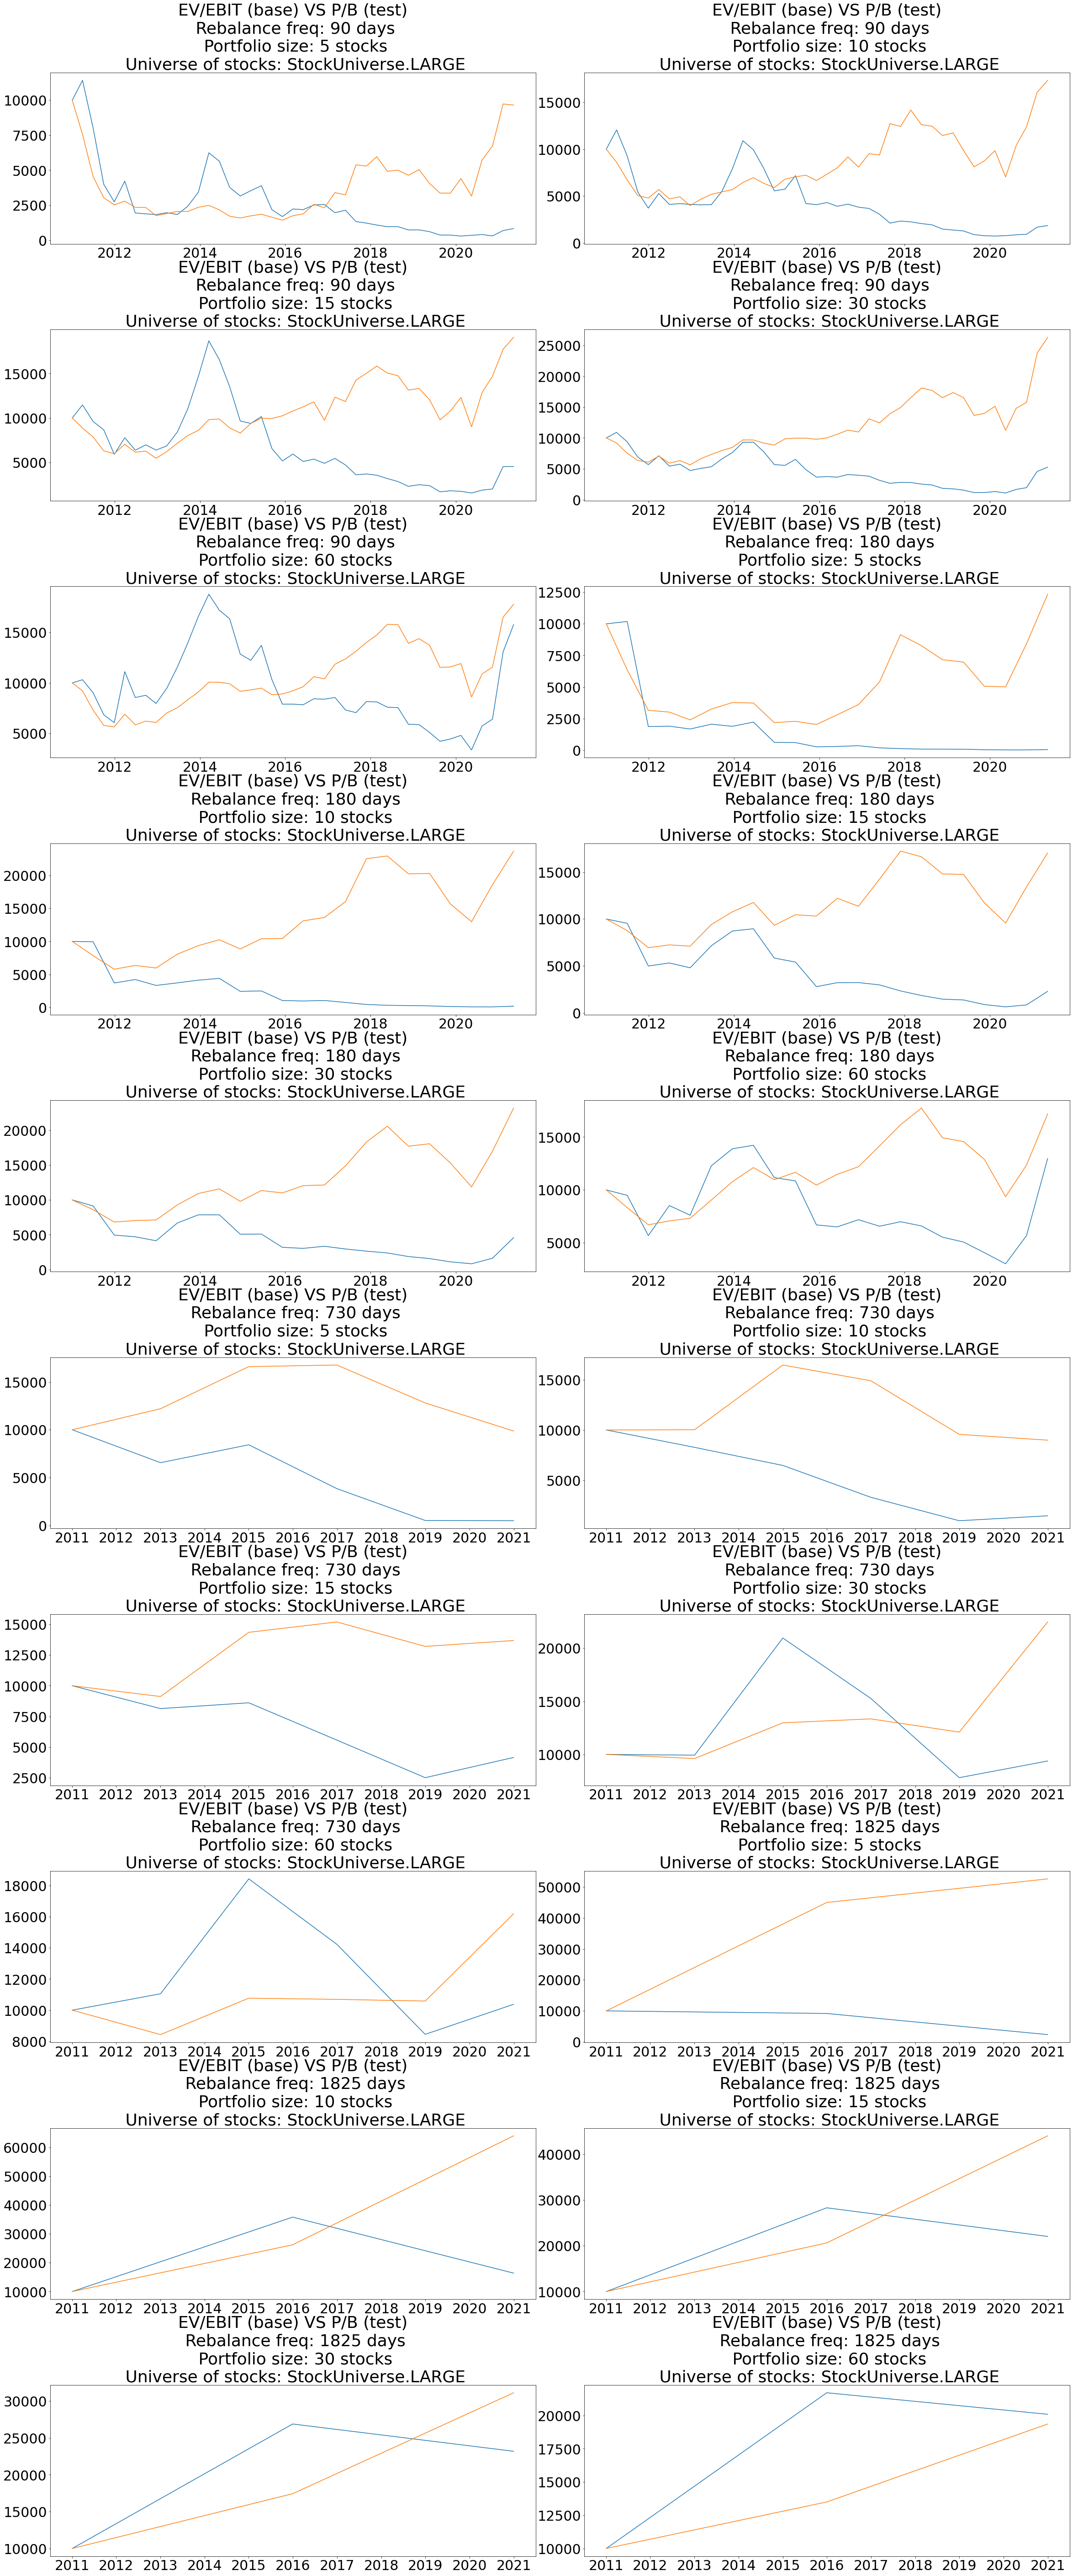

In [22]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    ax.plot(df.index, df['test_price'])
    ax.plot(df.index, df['base_price'])

num_rows = int(math.ceil(len(all_rebalance_days) * len(all_portfolio_sizes) / 2))
plt.rcParams["font.size"] = "30"    
fig, axes = plt.subplots(
    nrows=num_rows,    
    ncols=2,
    figsize=(40,100),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

row = 0
col = 0
for i, rebalance_days in enumerate(all_rebalance_days):
    for j, portfolio_size in enumerate(all_portfolio_sizes):
        ax = axes[row][col] if num_rows > 1 else axes[col]
        plot_backtest(all_df_results[rebalance_days][portfolio_size], BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE, ax)
        col = col + 1
        if col == 2:
            row = row + 1
            col = 0

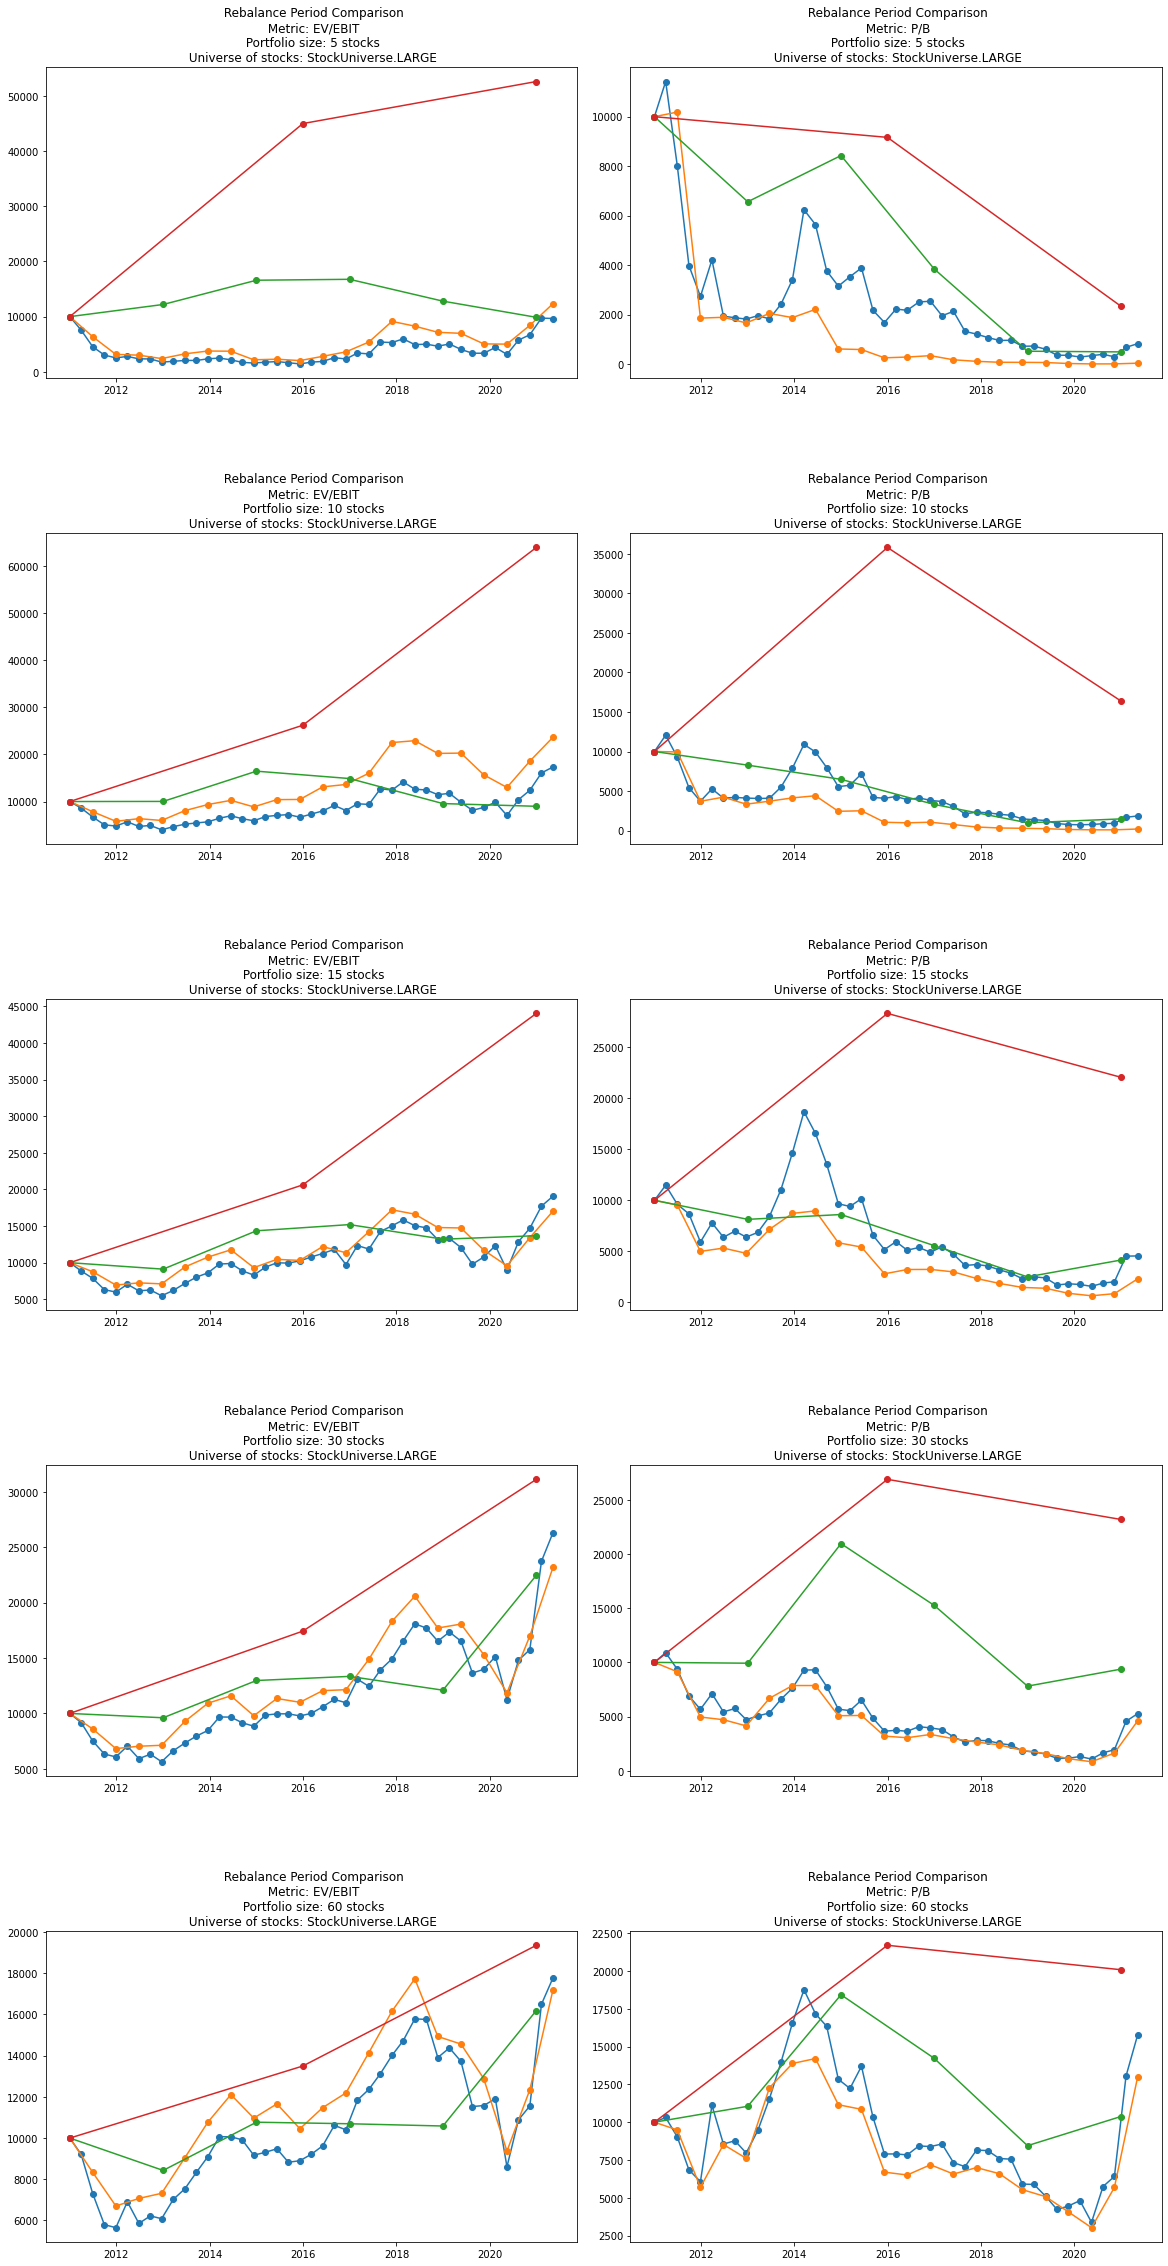

In [23]:
# For a specific portfolio size, plot performance of different rebalance days.

def plot_rebalance_days_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    portfolio_size: int,
    all_rebalance_days: List[int],
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title =(
        f' Rebalance Period Comparison\n'
        f' Metric: {str(metric)}\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    for rebalance_days in all_rebalance_days:
        series = df[f'price_{rebalance_days}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o', label=rebalance_days) 
    ax.legend(loc='upper left')

plt.rcParams["font.size"] = "10"    
fig, axes = plt.subplots(
    nrows=len(all_portfolio_sizes),
    ncols=2,
    figsize=(20,40),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

for i, portfolio_size in enumerate(all_portfolio_sizes):
    df_base = pd.DataFrame(columns=['date'])
    df_test = pd.DataFrame(columns=['date'])

    for j, rebalance_days in enumerate(all_rebalance_days):
        df = all_df_results[rebalance_days][portfolio_size].reset_index()
        base_prices = df[['date', 'base_price']].rename(columns={'base_price': f'price_{rebalance_days}'})
        test_prices = df[['date', 'test_price']].rename(columns={'test_price': f'price_{rebalance_days}'})        

        df_base = df_base.merge(base_prices, how='outer', on='date')
        df_test = df_test.merge(test_prices, how='outer', on='date')        

    df_base = df_base.set_index('date').sort_index()
    df_test = df_test.set_index('date').sort_index()
        
    plot_rebalance_days_investigation(df_base, BASE_METRIC, portfolio_size, all_rebalance_days, STOCKS_UNIVERSE, axes[i][0])
    plot_rebalance_days_investigation(df_test, TEST_METRIC, portfolio_size, all_rebalance_days, STOCKS_UNIVERSE, axes[i][1])    


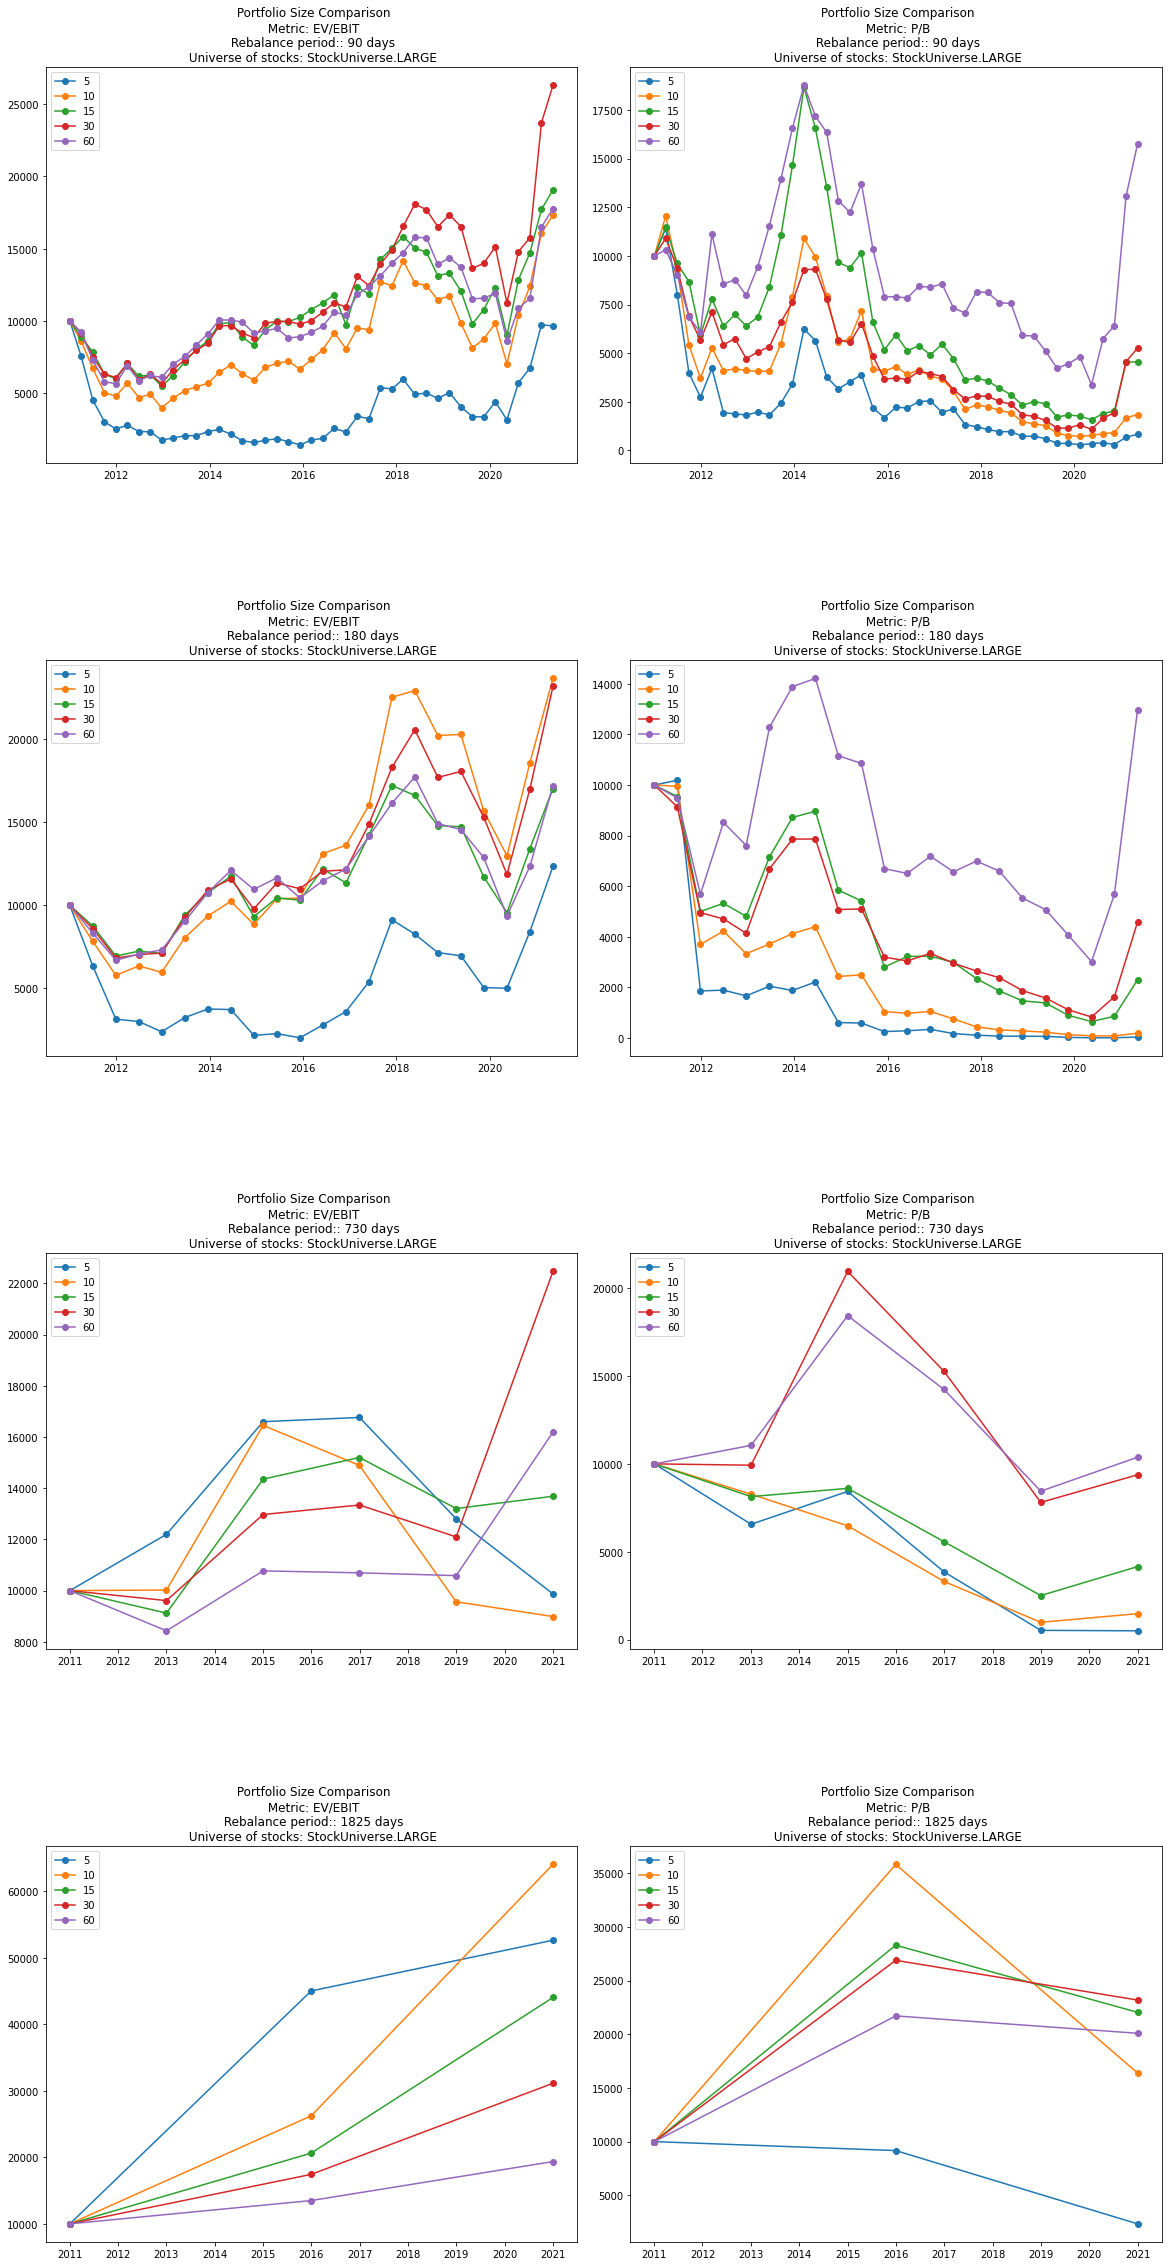

In [29]:
# For a specific rebalance period, plot performance of different rebalance days.

def plot_portfolio_size_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    rebalance_days: int,
    all_portfolio_sizes: List[int],
    stocks_universe: StockUniverse,
    ax: plt.Axes,
) -> None:
    ax.set(title =(
        f' Portfolio Size Comparison\n'
        f' Metric: {str(metric)}\n'
        f' Rebalance period:: {rebalance_days} days\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    for portfolio_size in all_portfolio_sizes:
        series = df[f'price_{portfolio_size}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o', label=portfolio_size) 
    ax.legend(loc='upper left')

plt.rcParams["font.size"] = "10"    
fig, axes = plt.subplots(
    nrows=len(all_rebalance_days),
    ncols=2,
    figsize=(20,40),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

for i, rebalance_days in enumerate(all_rebalance_days):
    df_base = pd.DataFrame(columns=['date'])
    df_test = pd.DataFrame(columns=['date'])

    for j, portfolio_size in enumerate(all_portfolio_sizes):
        df = all_df_results[rebalance_days][portfolio_size].reset_index()
        base_prices = df[['date', 'base_price']].rename(columns={'base_price': f'price_{portfolio_size}'})
        test_prices = df[['date', 'test_price']].rename(columns={'test_price': f'price_{portfolio_size}'})        

        df_base = df_base.merge(base_prices, how='outer', on='date')
        df_test = df_test.merge(test_prices, how='outer', on='date')        

    df_base = df_base.set_index('date').sort_index()
    df_test = df_test.set_index('date').sort_index()
        
    plot_portfolio_size_investigation(df_base, BASE_METRIC, rebalance_days, all_portfolio_sizes, STOCKS_UNIVERSE, axes[i][0])
    plot_portfolio_size_investigation(df_test, TEST_METRIC, rebalance_days, all_portfolio_sizes, STOCKS_UNIVERSE, axes[i][1])
